In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [3]:


!mkdir /kaggle/working/Corn
!mkdir /kaggle/working/Corn/test
!mkdir /kaggle/working/Corn/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Corn* /kaggle/working/Corn/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Corn* /kaggle/working/Corn/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Corn/train'
test_path='/kaggle/working/Corn/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
#         self.relu = nn.ReLU()
        self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*112*112, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
#         out = self.relu(out)
        out = self.mish1(out)
        out = self.maxpool(out)
#         out = self.cnn2(out)
#         out = self.relu2(out)
#         out = self.mish2(out)
#         out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [5]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].cuda(),data[1].cuda()
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [6]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].cuda(),data[1].cuda()
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [7]:
model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 386/386 [00:48<00:00,  7.97it/s]


Train Loss: 0.870 | Accuracy: 65.115


100%|██████████| 97/97 [00:10<00:00,  9.70it/s]


Test Loss: 0.710 | Accuracy: 73.017

Epoch : 2


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.633 | Accuracy: 75.008


100%|██████████| 97/97 [00:10<00:00,  9.63it/s]


Test Loss: 0.569 | Accuracy: 76.951

Epoch : 3


100%|██████████| 386/386 [00:40<00:00,  9.59it/s]


Train Loss: 0.556 | Accuracy: 76.946


100%|██████████| 97/97 [00:10<00:00,  9.33it/s]


Test Loss: 0.674 | Accuracy: 71.521

Epoch : 4


100%|██████████| 386/386 [00:40<00:00,  9.54it/s]


Train Loss: 0.520 | Accuracy: 78.479


100%|██████████| 97/97 [00:10<00:00,  8.87it/s]


Test Loss: 0.505 | Accuracy: 79.031

Epoch : 5


100%|██████████| 386/386 [00:41<00:00,  9.40it/s]


Train Loss: 0.504 | Accuracy: 78.803


100%|██████████| 97/97 [00:10<00:00,  9.55it/s]


Test Loss: 0.470 | Accuracy: 79.876

Epoch : 6


100%|██████████| 386/386 [00:41<00:00,  9.36it/s]


Train Loss: 0.481 | Accuracy: 79.703


100%|██████████| 97/97 [00:11<00:00,  8.62it/s]


Test Loss: 0.494 | Accuracy: 81.014

Epoch : 7


100%|██████████| 386/386 [00:41<00:00,  9.23it/s]


Train Loss: 0.474 | Accuracy: 79.922


100%|██████████| 97/97 [00:10<00:00,  9.35it/s]


Test Loss: 0.457 | Accuracy: 81.632

Epoch : 8


100%|██████████| 386/386 [00:41<00:00,  9.26it/s]


Train Loss: 0.442 | Accuracy: 81.293


100%|██████████| 97/97 [00:09<00:00, 10.05it/s]


Test Loss: 0.452 | Accuracy: 81.730

Epoch : 9


100%|██████████| 386/386 [00:39<00:00,  9.70it/s]


Train Loss: 0.435 | Accuracy: 81.730


100%|██████████| 97/97 [00:09<00:00, 10.00it/s]


Test Loss: 0.511 | Accuracy: 79.486

Epoch : 10


100%|██████████| 386/386 [00:40<00:00,  9.42it/s]


Train Loss: 0.430 | Accuracy: 81.374


100%|██████████| 97/97 [00:09<00:00,  9.87it/s]


Test Loss: 0.451 | Accuracy: 81.047

Epoch : 11


100%|██████████| 386/386 [00:39<00:00,  9.77it/s]


Train Loss: 0.418 | Accuracy: 82.176


100%|██████████| 97/97 [00:09<00:00,  9.94it/s]


Test Loss: 0.429 | Accuracy: 82.380

Epoch : 12


100%|██████████| 386/386 [00:40<00:00,  9.63it/s]


Train Loss: 0.426 | Accuracy: 81.649


100%|██████████| 97/97 [00:09<00:00, 10.01it/s]


Test Loss: 0.391 | Accuracy: 83.583

Epoch : 13


100%|██████████| 386/386 [00:39<00:00,  9.74it/s]


Train Loss: 0.415 | Accuracy: 81.682


100%|██████████| 97/97 [00:09<00:00,  9.71it/s]


Test Loss: 0.430 | Accuracy: 81.957

Epoch : 14


100%|██████████| 386/386 [00:41<00:00,  9.36it/s]


Train Loss: 0.406 | Accuracy: 82.306


100%|██████████| 97/97 [00:10<00:00,  9.68it/s]


Test Loss: 0.459 | Accuracy: 80.234

Epoch : 15


100%|██████████| 386/386 [00:40<00:00,  9.44it/s]


Train Loss: 0.405 | Accuracy: 82.209


100%|██████████| 97/97 [00:09<00:00,  9.94it/s]


Test Loss: 0.430 | Accuracy: 82.185

Epoch : 16


100%|██████████| 386/386 [00:41<00:00,  9.24it/s]


Train Loss: 0.399 | Accuracy: 82.306


100%|██████████| 97/97 [00:10<00:00,  9.32it/s]


Test Loss: 0.388 | Accuracy: 84.298

Epoch : 17


100%|██████████| 386/386 [00:40<00:00,  9.50it/s]


Train Loss: 0.397 | Accuracy: 82.420


100%|██████████| 97/97 [00:11<00:00,  8.74it/s]


Test Loss: 0.367 | Accuracy: 83.225

Epoch : 18


100%|██████████| 386/386 [00:40<00:00,  9.42it/s]


Train Loss: 0.390 | Accuracy: 83.158


100%|██████████| 97/97 [00:09<00:00, 10.06it/s]


Test Loss: 0.404 | Accuracy: 80.754

Epoch : 19


100%|██████████| 386/386 [00:40<00:00,  9.44it/s]


Train Loss: 0.391 | Accuracy: 82.744


100%|██████████| 97/97 [00:10<00:00,  8.90it/s]


Test Loss: 0.473 | Accuracy: 75.878

Epoch : 20


100%|██████████| 386/386 [00:41<00:00,  9.40it/s]


Train Loss: 0.392 | Accuracy: 82.509


100%|██████████| 97/97 [00:09<00:00,  9.76it/s]


Test Loss: 0.372 | Accuracy: 84.558

Epoch : 21


100%|██████████| 386/386 [00:39<00:00,  9.74it/s]


Train Loss: 0.387 | Accuracy: 83.182


100%|██████████| 97/97 [00:10<00:00,  9.07it/s]


Test Loss: 0.389 | Accuracy: 83.615

Epoch : 22


100%|██████████| 386/386 [00:39<00:00,  9.67it/s]


Train Loss: 0.381 | Accuracy: 83.077


100%|██████████| 97/97 [00:09<00:00, 10.08it/s]


Test Loss: 0.395 | Accuracy: 82.022

Epoch : 23


100%|██████████| 386/386 [00:38<00:00,  9.95it/s]


Train Loss: 0.382 | Accuracy: 83.190


100%|██████████| 97/97 [00:10<00:00,  9.27it/s]


Test Loss: 0.430 | Accuracy: 79.649

Epoch : 24


100%|██████████| 386/386 [00:39<00:00,  9.89it/s]


Train Loss: 0.387 | Accuracy: 82.955


100%|██████████| 97/97 [00:09<00:00, 10.16it/s]


Test Loss: 0.405 | Accuracy: 83.843

Epoch : 25


100%|██████████| 386/386 [00:38<00:00,  9.97it/s]


Train Loss: 0.376 | Accuracy: 83.514


100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


Test Loss: 0.386 | Accuracy: 84.103

Epoch : 26


100%|██████████| 386/386 [00:39<00:00,  9.88it/s]


Train Loss: 0.369 | Accuracy: 83.596


100%|██████████| 97/97 [00:09<00:00, 10.03it/s]


Test Loss: 0.388 | Accuracy: 82.380

Epoch : 27


100%|██████████| 386/386 [00:39<00:00,  9.87it/s]


Train Loss: 0.373 | Accuracy: 83.223


100%|██████████| 97/97 [00:10<00:00,  9.13it/s]


Test Loss: 0.417 | Accuracy: 83.095

Epoch : 28


100%|██████████| 386/386 [00:39<00:00,  9.84it/s]


Train Loss: 0.369 | Accuracy: 83.539


100%|██████████| 97/97 [00:09<00:00, 10.01it/s]


Test Loss: 0.378 | Accuracy: 82.542

Epoch : 29


100%|██████████| 386/386 [00:39<00:00,  9.85it/s]


Train Loss: 0.368 | Accuracy: 84.009


100%|██████████| 97/97 [00:10<00:00,  8.98it/s]


Test Loss: 0.348 | Accuracy: 85.696

Epoch : 30


100%|██████████| 386/386 [00:39<00:00,  9.81it/s]


Train Loss: 0.362 | Accuracy: 83.847


100%|██████████| 97/97 [00:09<00:00, 10.16it/s]


Test Loss: 0.348 | Accuracy: 85.273

Epoch : 31


100%|██████████| 386/386 [00:38<00:00,  9.91it/s]


Train Loss: 0.356 | Accuracy: 84.163


100%|██████████| 97/97 [00:10<00:00,  9.39it/s]


Test Loss: 0.346 | Accuracy: 85.338

Epoch : 32


100%|██████████| 386/386 [00:39<00:00,  9.72it/s]


Train Loss: 0.366 | Accuracy: 83.733


100%|██████████| 97/97 [00:09<00:00, 10.24it/s]


Test Loss: 0.389 | Accuracy: 83.485

Epoch : 33


100%|██████████| 386/386 [00:38<00:00,  9.93it/s]


Train Loss: 0.355 | Accuracy: 84.082


100%|██████████| 97/97 [00:10<00:00,  9.37it/s]


Test Loss: 0.370 | Accuracy: 84.460

Epoch : 34


100%|██████████| 386/386 [00:39<00:00,  9.70it/s]


Train Loss: 0.361 | Accuracy: 84.147


100%|██████████| 97/97 [00:09<00:00, 10.11it/s]


Test Loss: 0.368 | Accuracy: 83.940

Epoch : 35


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.360 | Accuracy: 84.179


100%|██████████| 97/97 [00:10<00:00,  9.30it/s]


Test Loss: 0.342 | Accuracy: 84.980

Epoch : 36


100%|██████████| 386/386 [00:39<00:00,  9.76it/s]


Train Loss: 0.345 | Accuracy: 84.617


100%|██████████| 97/97 [00:09<00:00, 10.18it/s]


Test Loss: 0.383 | Accuracy: 83.648

Epoch : 37


100%|██████████| 386/386 [00:39<00:00,  9.86it/s]


Train Loss: 0.351 | Accuracy: 84.512


100%|██████████| 97/97 [00:09<00:00, 10.19it/s]


Test Loss: 0.387 | Accuracy: 84.038

Epoch : 38


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.354 | Accuracy: 84.350


100%|██████████| 97/97 [00:10<00:00,  9.01it/s]


Test Loss: 0.352 | Accuracy: 85.273

Epoch : 39


100%|██████████| 386/386 [00:39<00:00,  9.82it/s]


Train Loss: 0.349 | Accuracy: 84.236


100%|██████████| 97/97 [00:09<00:00,  9.88it/s]


Test Loss: 0.336 | Accuracy: 85.176

Epoch : 40


100%|██████████| 386/386 [00:39<00:00,  9.81it/s]


Train Loss: 0.350 | Accuracy: 84.147


100%|██████████| 97/97 [00:10<00:00,  9.53it/s]


Test Loss: 0.367 | Accuracy: 83.257

Epoch : 41


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.345 | Accuracy: 84.447


100%|██████████| 97/97 [00:09<00:00, 10.14it/s]


Test Loss: 0.350 | Accuracy: 84.850

Epoch : 42


100%|██████████| 386/386 [00:40<00:00,  9.65it/s]


Train Loss: 0.347 | Accuracy: 84.747


100%|██████████| 97/97 [00:09<00:00, 10.52it/s]


Test Loss: 0.403 | Accuracy: 79.064

Epoch : 43


100%|██████████| 386/386 [00:40<00:00,  9.58it/s]


Train Loss: 0.345 | Accuracy: 84.293


100%|██████████| 97/97 [00:09<00:00, 10.15it/s]


Test Loss: 0.546 | Accuracy: 72.237

Epoch : 44


100%|██████████| 386/386 [00:39<00:00,  9.84it/s]


Train Loss: 0.341 | Accuracy: 84.925


100%|██████████| 97/97 [00:09<00:00, 10.47it/s]


Test Loss: 0.336 | Accuracy: 85.891

Epoch : 45


100%|██████████| 386/386 [00:40<00:00,  9.61it/s]


Train Loss: 0.349 | Accuracy: 84.309


100%|██████████| 97/97 [00:09<00:00, 10.11it/s]


Test Loss: 0.368 | Accuracy: 84.135

Epoch : 46


100%|██████████| 386/386 [00:39<00:00,  9.86it/s]


Train Loss: 0.342 | Accuracy: 84.804


100%|██████████| 97/97 [00:09<00:00, 10.03it/s]


Test Loss: 0.347 | Accuracy: 85.078

Epoch : 47


100%|██████████| 386/386 [00:40<00:00,  9.57it/s]


Train Loss: 0.345 | Accuracy: 84.698


100%|██████████| 97/97 [00:09<00:00,  9.78it/s]


Test Loss: 0.446 | Accuracy: 83.583

Epoch : 48


100%|██████████| 386/386 [00:39<00:00,  9.84it/s]


Train Loss: 0.343 | Accuracy: 84.650


100%|██████████| 97/97 [00:09<00:00, 10.14it/s]


Test Loss: 0.420 | Accuracy: 83.550

Epoch : 49


100%|██████████| 386/386 [00:40<00:00,  9.46it/s]


Train Loss: 0.343 | Accuracy: 84.569


100%|██████████| 97/97 [00:09<00:00, 10.09it/s]


Test Loss: 0.353 | Accuracy: 85.078

Epoch : 50


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.337 | Accuracy: 84.877


100%|██████████| 97/97 [00:09<00:00,  9.75it/s]


Test Loss: 0.379 | Accuracy: 83.030

Epoch : 51


100%|██████████| 386/386 [00:42<00:00,  9.06it/s]


Train Loss: 0.335 | Accuracy: 84.990


100%|██████████| 97/97 [00:09<00:00,  9.73it/s]

Test Loss: 0.374 | Accuracy: 83.940


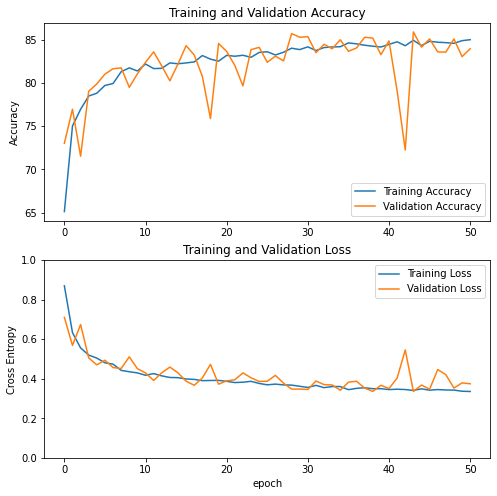

In [9]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [11]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [12]:
torch.save(AlexNet_model.state_dict(), '/kaggle/working/alexnet.pk1')

NameError: name 'AlexNet_model' is not defined

In [ ]:
model_scripted = torch.jit.script(AlexNet_model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import
FileLinkFileLink(r'AlexNet_model.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'alexnet.pk1')